<a href="https://colab.research.google.com/github/gstonecipher/ENVIR_ST_956_FinalProject_ChangeDetection/blob/main/Stonecipher_ChangeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Examining the impacts of a 2007 windstorm in Lewis & Clark National Park using mutliple change detection methods

This notebook uses multiple change detection methods to examine the landscape change caused by a windstorm that occured in Lewis and Clark National Historical Park in December of 2007. Two Landsat 5 SR images, one from July of 2007 and the other from 2008, are used to detect the change. Both images have 30 m resolution, and contain six bands - blue, green, red, NIR, SWIR1, and SWIR2.

The change detection methods use are: image differencing, image ratio, and change vector analysis.

The images were acquired using Google Earth Engine. [Code here](https://code.earthengine.google.com/218ab60e5e8ae331bb096eb06ae320a5?noload=1).

# Set up Notebook

This code block checks for and installs any updates to the operating system:

In [ ]:
#!add-apt-repository ppa:ubuntugis/ppa
#!apt update
#!apt install gdal-bin libgdal-dev
#!pip3 install rasterio
#!pip install geopandas

This block imports the libraries that are necessary for this analysis:

In [ ]:
# import libraries
import numpy as np
import random
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
import geopandas as gpd

# Import and Visualize Images

Google Earth Engine was used to locate and export two Landsat 5 images of the study area from before and after the disturbances. The first image is from July 10, 2007, and the second images is from July 12, 2008.

This code block links the Colab notebook to the Google Drive folder that contains the images. It then copies the images over into the Colab notebook and examines the metadata of each image to make sure that they're the same size. The images are then each read in as a numpy array, with the format: bands, rows, columns.

In [ ]:
#grab images from Google Drive
# link Google Drive folders
#from google.colab import drive
#drive.mount('/content/gdrive')

!ls /content/gdrive/My\ Drive/GEE_Images/  # list the contents of the folder


!cp /content/gdrive/My\ Drive/GEE_Images/lewi_*.tif . #copy everything into this location

#examine metadata of the images - make sure that they're the same size
#!gdalinfo lewi_20070710.tif
#!gdalinfo lewi_20080712.tif

before = rasterio.open('lewi_studyarea_20070710.tif').read()    #read the before image in as a 3-dimensional numpy array
print(before.shape) # bands, rows, columns

after = rasterio.open('lewi_studyarea_20080712.tif').read()  #read the after image in as a 3-dimensional numpy array
print(after.shape)

#create objects that just read in the metadata
before_meta = rasterio.open('lewi_studyarea_20070710.tif')
after_meta = rasterio.open('lewi_studyarea_20080712.tif')



lewi_20070710.tif  lewi_larger_20070710.tif  LEWI.shp
lewi_20080712.tif  lewi_larger_20080712.tif  LEWI.shx
LEWI.cpg	   LEWI.prj		     lewi_studyarea_20070710.tif
LEWI.dbf	   LEWI.sbx		     lewi_studyarea_20080712.tif
(7, 212, 223)
(7, 212, 223)


This next block checks the maximum value in each array. If the value is greater than 10000, it's set to 10000.

In [ ]:
print("The old maximum was " + str(before.max()))

before = np.where(before > 10000, 10000, before)
after = np.where(after > 10000, 10000, after)

print("The new maximum is " + str(before.max()))

The old maximum was 20000
The new maximum is 10000


A lot of clearing for agriculture occurs right near Lewis & Clark National Historical Park. To better determine cutoff values specifically for wind damage, we'll also load in the shapefile of Fort Clatsop, the largest unit in the park. Any changes that occur within this area are due to tree toppling, not agriculture or clearing, as these activities are prohibited in the park.

epsg:26910
epsg:32610


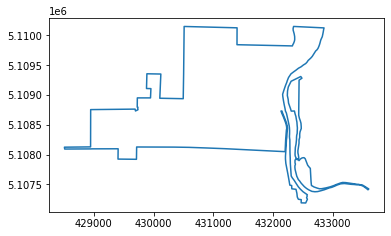

In [ ]:
!cp /content/gdrive/My\ Drive/GEE_Images/LEWI.* . #copy all parts of the shapefile into this location
LEWI = gpd.read_file('LEWI.shp') # read the shapefile in using geopandas
LEWI.head(5) # examine the top 5 rows of the shapefile

study_area = LEWI[LEWI.SiteName == "Fort Clatsop"]  # pull the fort clatsop unit out of the shapefile
print(study_area.crs) # examine the coordinate system of the shapefile

study_area = study_area.to_crs(epsg = 32610)  # reproject to match the coordinate system of the images
print(study_area.crs) # check to make sure this worked

study_area.boundary.plot() # visualize the study area

This code block visualizes the true color composite (R-G-B) and false color composite (NIR-R-G) for both images. The arrays are reshaped from bands, rows, columns to rows, columns, bands so that they can be used in image processing tasks.

The shapefile of the Fort Clatsop unit of Lewis and Clark National Historical Park is also overlayed on the images. To get the layers to align, the axes had to be rescaled into the coordinate system (UTM). The bounding box of the original images is used to set the axis minimums and maximums.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


BoundingBox(left=427305.0, bottom=5105895.0, right=433995.0, top=5112255.0)
True color composites


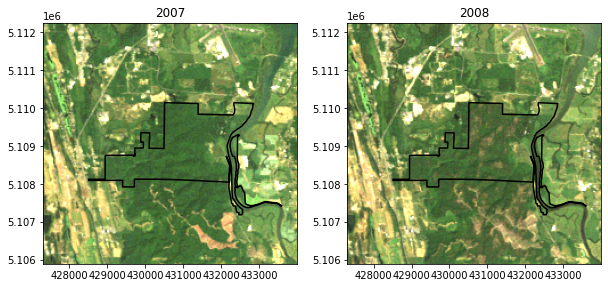

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


False color composites


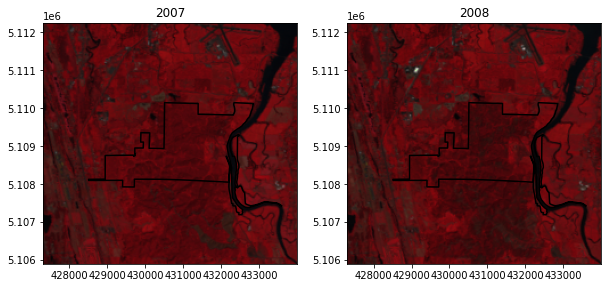

In [ ]:
# visualize true and false color composites
# images are typically scaled by 10000 going from reflectance to scaled reflectance
# however, for visualization purposes, the true color images are scaled to 1000
# reshape as image to switch from bands-rows-columns to rows-columns-bands

# pull bounding box from image metadata
BBox = before_meta.bounds

# examine BBox coordinates
print(BBox) # x_min, y_min, x_max, y_max
extent = [BBox[0], BBox[2], BBox[1], BBox[3]] # change to x_min, x_max, y_min, y_max


fig, axs = plt.subplots(1, 2, figsize=(10, 5)) #create canvas for first two plots
print('True color composites')
#2007 true color
study_area.boundary.plot(color = "black", ax=axs[0]) # add study area shapefile
axs[0].imshow(reshape_as_image(before[[2,1,0],:]*.001), extent = extent) # grab R, G, B bands for all pixels, scale the reflectance, and set the new extent
axs[0].set_title("2007")

#2008 true color
study_area.boundary.plot(color = "black", ax=axs[1])
axs[1].imshow(reshape_as_image(after[[2,1,0],:]*.001), extent = extent) # grab R, G, B bands for all pixels, scale the reflectance, and set the new extent
axs[1].set_title("2008")
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5)) #create canvas for next two plots
print('False color composites')
#2007 false color
study_area.boundary.plot(color = "black", ax=axs[0]) # add study area shapefile
axs[0].imshow(reshape_as_image(before[[3,2,1],:]*.0001), extent = extent) # grab NIR, R, G bands for all pixels, scale the reflectance, and set the new extent
axs[0].set_title("2007")

# 2008 false color
study_area.boundary.plot(color = "black", ax=axs[1])
axs[1].imshow(reshape_as_image(after[[3,2,1],:]*.0001), extent = extent) # grab NIR, R, G bands for all pixels, scale the reflectance, and set the new extent
axs[1].set_title("2008")
plt.show()

# Change Detection through Image Differencing

The image differencing technique uses simple band-by-band subtraction for every pixel to create a difference image for that band. A histogram of the difference image can then be used to locate the change thresholds for the image. Given that the two images are from the same area, we generally expect the histogram to have a normal distribution, with the majority of the pixels seeing no change. While the histogram is expected to be centered around 0, this may not be true if the two images have differing overall brightness. The pixels in the tails of the histogram have most likely changed in the time period between when the images were taken - identifying the change threshold allows a new image to be made showing changed areas and unchanged areas.

Since the disturbance that we're trying to examine (a windstorm) caused changes to vegetation (trees were blown over), we'll use the NIR band for image differencing. Since vegetation reflects strongly in the NIR, a large decrease in NIR could be indicative of windstorm damage. 

This code block slices the arrays to grab only the NIR band of each image (at index 3, since python has 0-based indexing), and then displays the two NIR images.

NIR in 2007 and 2008


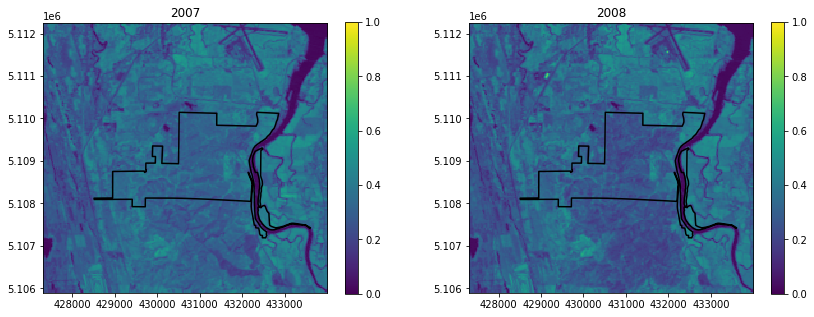

In [ ]:
#subsest the arrays to grab specific bands
before_NIR = before[3,:]*.0001 #grab fourth slice of the before image (the NIR band), leave rows and columns alone

after_NIR = after[3,:]*.0001   #grab fourth slice of the after image(the NIR band), leave rows and columns alone

print("NIR in 2007 and 2008")
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
im1 = axs[0].imshow(before_NIR, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=axs[0])
axs[0].set_title("2007")
plt.colorbar(im1, ax = axs[0])

im2 = axs[1].imshow(after_NIR, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=axs[1])
axs[1].set_title("2008")
plt.colorbar(im2, ax = axs[1])

plt.show()

This next code block calculates the NIR difference between the two images.

(212, 223)
NIR Difference Image


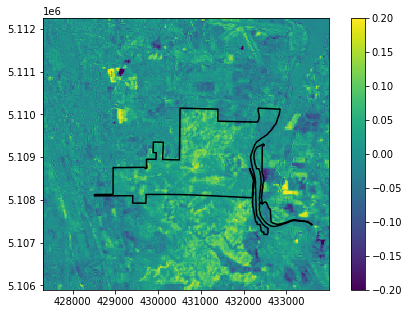

In [ ]:
NIR_diff = before_NIR - after_NIR  #calculate the difference in NIR between the two images

print(NIR_diff.shape)
rows = NIR_diff.shape[0]
cols = NIR_diff.shape[1]

# visualize the difference image
print("NIR Difference Image")
fig, ax = plt.subplots(figsize=(8, 5))
plt.imshow(NIR_diff, vmin = -0.2, vmax = 0.2, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=ax)
plt.colorbar()
plt.show()

This next code block creates the histogram for the image above. Since the image is clipped to a relatively small area, here we'll use 50 bins instead of 100.

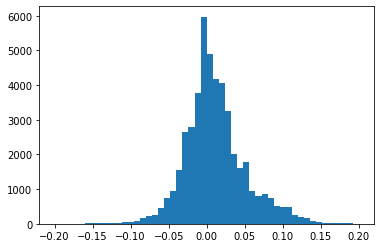

In [ ]:
# visualize its histogram
n_bins = 50
N, bins, patches = plt.hist(NIR_diff.reshape(rows*cols), bins=n_bins,range=[-0.2, 0.2])

As expected, the data generally follows a normal distribution, centered around 0. Pixels with a value of about 0 represent no change. Since we subtracted the after image from the before image, pixels that experienced vegetation loss will be at the far right side of the histogram. This is because we expect that these pixels went from a high NIR value to a low NIR value. High (2007) - low (2008) = high (difference image). In examining the histogram, we'll try .08 as a cutoff value for change.

This next code block uses this cutoff value to make a binary map - change and no change.

Change Image


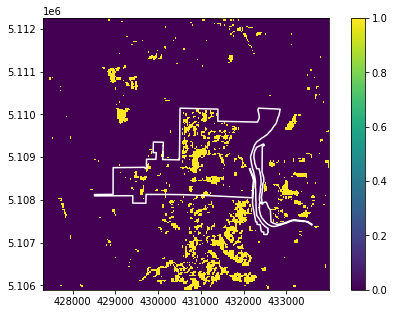

In [ ]:
NIR_changeim = NIR_diff >= 0.08 #creates a boolean image - True/False
#print(NIR_changeim)

NIR_changeim = NIR_changeim.astype(np.uint8) # changes from boolean to integers - 1/0
#print(NIR_changeim)

print("Change Image")
fig, ax = plt.subplots(figsize=(8, 5))
plt.imshow(NIR_changeim, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=ax)
plt.colorbar()
plt.show()

In the above map, areas that changed (NIR decreased) are colored yellow, and everything else is colored purple. Note that this map does not distinguish areas where NIR increased from areas that did not change.

The next code block will export this image as a GeoTIFF using the properties of one of the original input images.

In [ ]:
# start generating variables used for writing the geotiff image
transform = before_meta.transform # transform parameters read from the original image
crs = before_meta.crs # CRS parameters read from the original image

# write the file in one go using all options
with rasterio.open(
    'nir_change_detection.tif', # set name of new image
    'w', # write mode 
    driver='GTiff', # type of image (geotiff)
    height=NIR_changeim.shape[0], # pull height of difference image
    width=NIR_changeim.shape[1],  # pull width of difference image
    count=1, # number of images
    dtype='uint8', # data type
    crs = crs,  # pull crs of original image
    transform=transform, # pull transfrom parameters of original image
) as dst:
    dst.write(NIR_changeim, 1) 

# check if the file exists
!gdalinfo nir_change_detection.tif

from google.colab import files
# files.download('nir_change_detection.tif') # save the image to personal computer

Driver: GTiff/GeoTIFF
Files: nir_change_detection.tif
Size is 223, 212
Coordinate System is:
PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32610"]]
Origin = (427305.000000000000000,5112255.000000000000000)
Pixel Size = (30.000000000000000,-30.000000000000000)
Metadata:
  AREA_OR_POINT=

In general, the change patches aren't very easy to see in a single band. Now, we'll create an NDVI image for each year, and take the difference between those.

The following code block creates the two NDVI images and visualizes them.

NDVI in 2007 and 2008


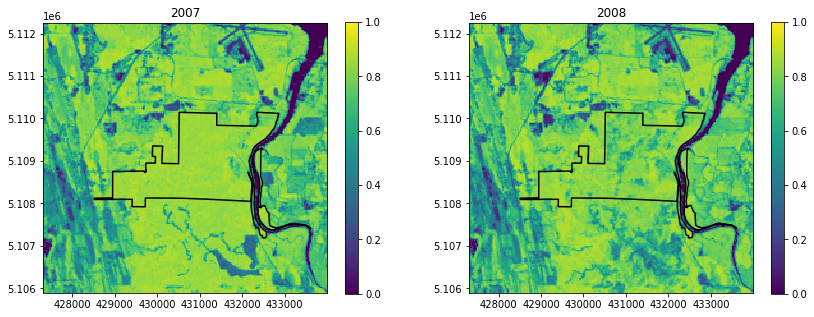

In [ ]:
# calculate NDVI for every pixel in both images
# use NIR band (index 3) and R band (index 2) 
ndvi_2007 = (before[3,:] - before[2,:]) / (before[3,:] + before[2,:]) # 2007 NDVI
ndvi_2008 = (after[3,:] - after[2,:]) / (after[3,:] + after[2,:]) #2008 NDVI

# visualize the two images
print("NDVI in 2007 and 2008")
fig, axs = plt.subplots(1,2,figsize=(14, 5))

im1 = axs[0].imshow(ndvi_2007, vmin = 0, vmax = 1, interpolation='nearest', extent = extent) # 2007 NDVI image
study_area.boundary.plot(color = "black", ax=axs[0]) # study area
axs[0].set_title("2007")
plt.colorbar(im1, ax = axs[0])

im2 = axs[1].imshow(ndvi_2008, vmin = 0, vmax = 1, interpolation='nearest', extent = extent) # 2008 NDVI image
study_area.boundary.plot(color = "black", ax=axs[1]) # study area
axs[1].set_title("2008")
plt.colorbar(im2, ax = axs[1])

plt.show()

Like with NIR, we'll then take the difference between 2007 NDVI and 2008 NDVI for every pixel. For areas with vegetation loss, we expect to see high NDVI in 2007 and low NDVI in 2008. Therefore, high (2007) - low (2008) = high; in our difference image, pixels with a high value may have experienced vegetation loss.

The below code calculates the difference image and then visualizes it.

NDVI difference image


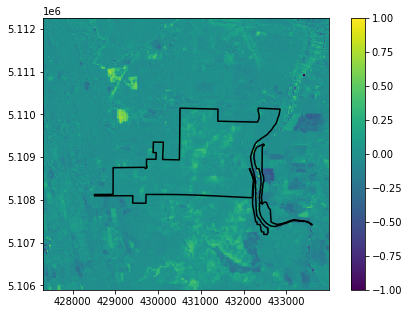

In [ ]:
ndvi_diff = ndvi_2007 - ndvi_2008 # calculate difference

# visualize the image
print("NDVI difference image")
fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(ndvi_diff, vmin = -1, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=ax)
plt.colorbar()
plt.show()



In the image above, areas that are yellow saw a decrease in NDVI between 2007 and 2008. Areas that are dark blue saw an increase in NDVI, perhaps indicating either forest regeneration, or agriculture. Agriculture is likely, given the regular shape of the patches, the location outside of the park boundary, and comparison to the true color images.

Next, we show the histogram for the NDVI difference image.

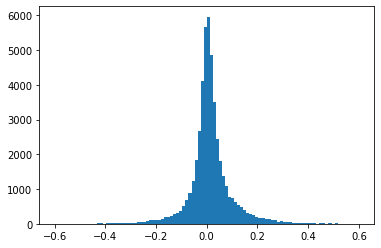

In [ ]:
# visualize its histogram
n_bins = 100
N, bins, patches = plt.hist(ndvi_diff.reshape(rows*cols), bins=n_bins,range=[-0.6, 0.6])



Again, the histogram is centered right around 0, with a longer right tail. We know that our change pixels are in this tail, so we'll select a cut-off value. In this case, we'll select 0.18.

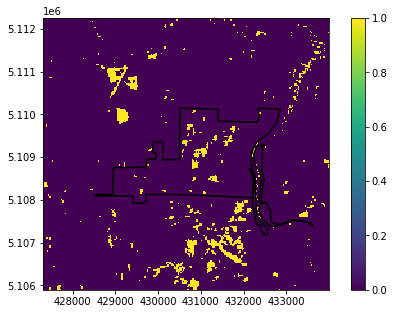

In [ ]:
change_ndvi = ndvi_diff >= 0.18
#print(change_ndvi)
change_ndvi = change_ndvi.astype(np.uint8)
#print(change_ndvi)

# np.where
# create 2D numpy array - same size as output image - populate with 0s
# using where statement, emptyimage.where if ... else...
fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(change_ndvi, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=ax)
plt.colorbar()
plt.show()



Now, we'll create a change image that also shows vegetation growth. This requires creating three classes - vegetation recovery (low values), vegetation loss (high values), and no change.

3 class image


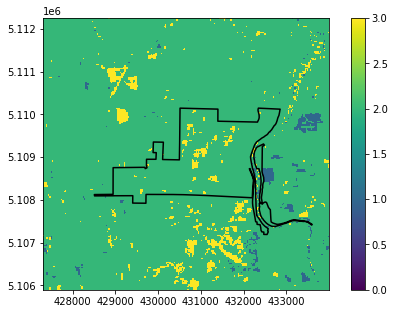

In [ ]:
# create an empty array of zeros, the same size as the difference image
three_class = np.zeros_like(change_ndvi)

# set three classification
three_class = np.where((ndvi_diff <= -0.2), 1, three_class) # vegetation recovery
three_class = np.where(ndvi_diff >= .18, 3, three_class) # vegetation loss
three_class = np.where((ndvi_diff > -.2) & (change_ndvi < .18), 2, three_class) # no change

print("3 class image")
#visualize the image
fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(three_class, vmin = 0, vmax = 3, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=ax)
plt.colorbar()
plt.show()

# Change Detection through Tasseled-Cap

Now, we'll use the KT tasseled cap transformation to calculate brightness, greenness, and wetness for both images. 

The code below defines a function that applies the tasseled cap transform to reflectance image.


In [ ]:
def tasseled_cap_tm(rast, reflectance=True):
    '''
    Applies the Tasseled Cap transformation for TM data. Assumes that the TM
    data are TM reflectance data (i.e., Landsat Surface Reflectance). The
    coefficients for reflectance factor data are taken from Crist (1985) in
    Remote Sensing of Environment 17:302.
    '''
    if reflectance:
        # Reflectance factor coefficients for TM bands 1-5 and 7; they are
        #   entered here in tabular form so they are already transposed with
        #   respect to the form suggested by Kauth and Thomas (1976)
        r = np.array([
            ( 0.2043, 0.4158, 0.5524, 0.5741, 0.3124, 0.2303),
            (-0.1603,-0.2819,-0.4934, 0.7940,-0.0002,-0.1446),
            ( 0.0315, 0.2021, 0.3102, 0.1594,-0.6806,-0.6109),
            (-0.2117,-0.0284, 0.1302,-0.1007, 0.6529,-0.7078),
            (-0.8669,-0.1835, 0.3856, 0.0408,-0.1132, 0.2272),
            ( 0.3677,-0.8200, 0.4354, 0.0518,-0.0066,-0.0104)
        ], dtype=np.float32)

    else:
        raise NotImplemented('Only support for Landsat TM reflectance has been implemented')

    shp = rast.shape

    # Can accept either a gdal.Dataset or numpy.array instance
    # checks to see the format of the raster data
    # if it's not a numpy array, it's read as an array and then reshaped to 2 dimensions
    if not isinstance(rast, np.ndarray):
        x = rast.ReadAsArray().reshape(shp[0], shp[1]*shp[2]) # if image is a gdal data set, read it as array first

    else:
        x = rast.reshape(shp[0], shp[1]*shp[2]) # if it is a numpy array, it's reshaped to 2 dimensions

    return np.dot(r, x).reshape(shp) # use dot product matrix multiplication to create the new image


Now, we'll apply the tasseled cap transform function to our images and visualize the false color images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Tasseled-cap in 2007 and 2008


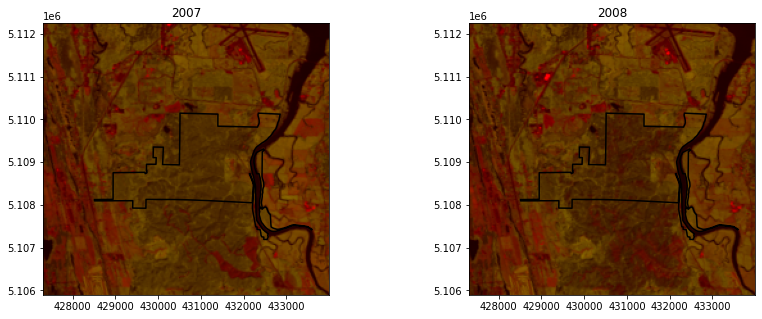

In [ ]:
# apply the KT transformation
kt_2007 = tasseled_cap_tm(before[0:6,:]*0.0001)  
kt_2008 = tasseled_cap_tm(after[0:6,:]*0.0001)  

# visualize the two false color composites 
print("Tasseled-cap in 2007 and 2008")
fig, axs = plt.subplots(1,2,figsize=(14, 5))

im1 = axs[0].imshow(reshape_as_image(kt_2007[[0,1,2], :]), extent = extent) # 2007 NDVI image
study_area.boundary.plot(color = "black", ax=axs[0]) # study area
axs[0].set_title("2007")

im2 = axs[1].imshow(reshape_as_image(kt_2008[[0,1,2], :]), extent = extent) # 2008 NDVI image
study_area.boundary.plot(color = "black", ax=axs[1]) # study area
axs[1].set_title("2008")

plt.show()



Now, as before, we'll calculate the difference image. In this case, we'll calculate for the brightness, greenness, and wetness bands, and display all three images.

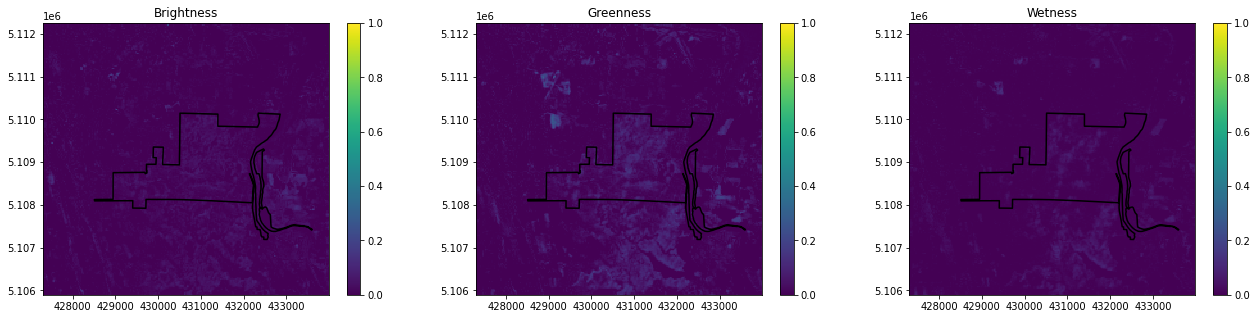

In [ ]:
# compute difference images for brightness, greenness, and wetness
kt_diff_bright = kt_2007[0,:] - kt_2008[0,:]
kt_diff_green = kt_2007[1,:] - kt_2008[1,:]
kt_diff_wet = kt_2007[2,:] - kt_2008[2,:]

# display all 3 difference images
fig, axs = plt.subplots(1,3,figsize=(22,5))
im1 = axs[0].imshow(kt_diff_bright, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=axs[0])
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("Brightness")

im2 = axs[1].imshow(kt_diff_green, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=axs[1])
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("Greenness")

im3 = axs[2].imshow(kt_diff_wet, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=axs[2])
plt.colorbar(im2, ax=axs[2])
axs[2].set_title("Wetness")
plt.show()



From looking at the above difference images, the change is by far the most visible in the greenness image. We'll use this image for our change detection.

Once again, we'll create a histogram, pick a threshold, and create a binary map.

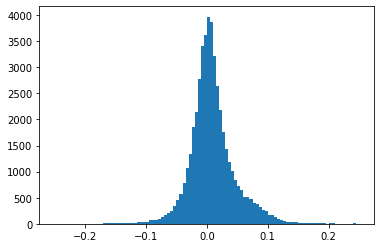

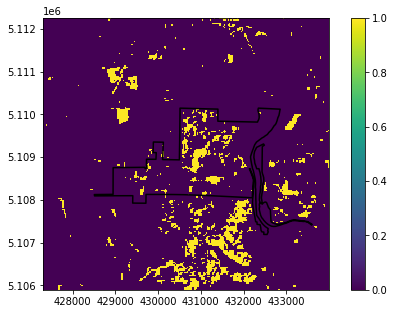

In [ ]:
# visualize its histogram
n_bins = 100
N, bins, patches = plt.hist(kt_diff_green.reshape(rows*cols), bins=n_bins,range=[-0.25, 0.25])

# threshold the image
change_kt_green = kt_diff_green >= 0.07
#print(change_ndvi)
change_kt_green = change_kt_green.astype(np.uint8)
#print(change_ndvi)

# plot thresholded image
fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(change_kt_green, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=ax)
plt.colorbar()
plt.show()


# Change Detection through Change Vector Analysis

For our final change detection analysis, we'll use change vector analysis. This analysis uses two bands to create points in cartesian space, and then traces the trajectory of each point between the two years. The form of the change can be inferred from the direction of the pixel trajectory, and the intensity of the change can be inferred from the magnitude. As above, thesholds can then be used to separate the change pixels.

Since we're looking at change in vegetation, we'll use the red band and the NIR band. The red band will be on the X axis, and the NIR band will be on the Y axis.

The code block below pulls 1000 random samples from the images, and plots the R vs. NIR values for both 2007 and 2008 in a scatterplot.

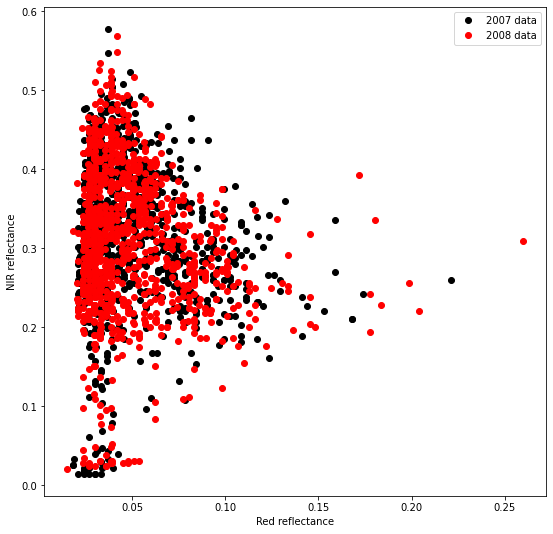

In [ ]:
# select 1000 random samples between 0 and total # of pixels (rows*columns)
random.seed(5) # set seed so same random sample is pulled each time
idx=random.sample(range(rows*cols),1000) 

# grab 2007 Red and NIR 
xy_2007 = (before[[2,3],:]*0.0001).reshape(2,rows*cols) # reshape into 2D array

# grab 2008 Red and NIR
xy_2008 = (after[[2,3],:]*0.0001).reshape(2,rows*cols) # reshape into 2D array

# create scatterplot
plt.figure(figsize=(9, 9))
plt.plot(xy_2007[0,idx], xy_2007[1,idx], 'ko ', label='2007 data') # pull sample from R and NIR for 2007
plt.plot(xy_2008[0,idx], xy_2008[1,idx], 'ro', label='2008 data')
plt.xlabel('Red reflectance')
plt.ylabel('NIR reflectance')
plt.legend()


In general, the points seem to be shifting to the right, indicating an increase in redness, indicative of a decrease in vegetation. In some areas, points also seem to be shifting down, indicating a decrease in NIR.

In the next block, we'll use Euclidean distance to calculate the vector magnitude for each pixel. Euclidean distance uses the coordinates of the 2007 location and the 2008 location.

0.0
1.0793512171670536


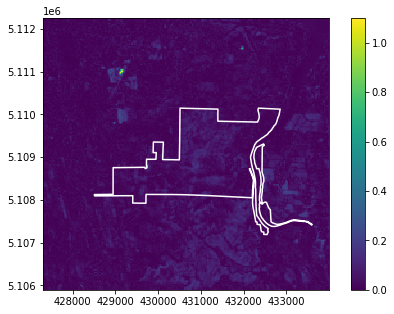

In [ ]:
x1 = xy_2007[0,:] # 2007 x coordinate (red reflectance) for all pixels
y1 = xy_2007[1,:] # 2007 y coordinate (NIR refelctance) for all pixels
x2 = xy_2008[0,:] # 2008 y coordinate (red refelctance) for all pixels
y2 = xy_2008[1,:] # 2008 y coordinate (NIR refelctance) for all pixels

# Euclidean distance calculation 
change_magnitude = np.sqrt((x2-x1)**2 + (y2-y1)**2)

print(change_magnitude.min())
print(change_magnitude.max())

fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(change_magnitude.reshape(rows,cols), vmin = 0, vmax = 1.1, interpolation='nearest', extent = extent) # reshape back into image (3D array)
study_area.boundary.plot(color = "white", ax=ax)
plt.colorbar()
plt.show()

The maximum magnitude of change in the image above was 1.08. However, this data point is clearly an outlier. Therefore, the max is rescaled to make other changes more visible in the image below.

change magnitude rescaled


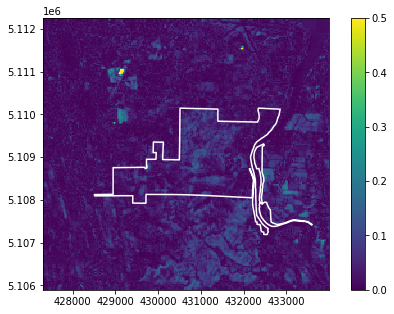

In [ ]:
print('change magnitude rescaled')
fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(change_magnitude.reshape(rows,cols), vmin = 0, vmax = .5, interpolation='nearest', extent = extent) # reshape back into image (3D array)
study_area.boundary.plot(color = "white", ax=ax)
plt.colorbar()
plt.show()

In the above image, the change areas appear to be those with a magnitude greater than about .1. This value will be used as a threshold below.

Next we'll look at the direction of change. Angles are calculated counter-clockwise from the horizontal axis. To account for different "quadrants" we would need to make adjustments as in:
- x = positive; y = positive = Quadrant I - do nothing
- x = negative; y = positive = Quadrant II - add 180
- x = negative; y = negative = Quadrant III - add 180
- x = positive; y = negative = Quadrant IV - add 360

                    |
               II   |  I
                    |
            ------------------
                    |
              III   |  IV
                    |


In [ ]:
# generate vector components for convenience
a = x2 - x1
b = y2 - y1

# calculate change direction as degrees.  Note that arctan returns results 
# in radians and np.degrees converts that to degrees
change_direction = np.degrees(np.arctan(b/a))

# correct for quadrants
change_direction[(a < 0) & (b > 0)] = change_direction[(a < 0) & (b > 0)] + 180.0
change_direction[(a < 0) & (b < 0)] = change_direction[(a < 0) & (b < 0)] + 180.0 
change_direction[(a > 0) & (b < 0)] = change_direction[(a > 0) & (b < 0)] + 360.0

#print(np.nanmin(change_direction))
#print(np.nanmax(change_direction))




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Now, we'll plot the image by the change direction, as well as an illustration of a small sample of the vectors.

change direction


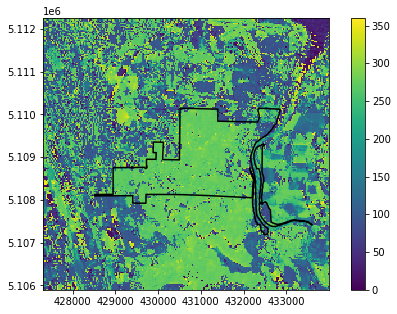

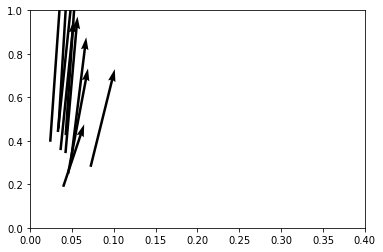

In [ ]:
#plot the change direction
print('change direction')
fig, ax = plt.subplots(figsize=(8,5))
plt.imshow(change_direction.reshape(rows,cols), vmin = 0, vmax = 360, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "black", ax=ax)
plt.colorbar()
plt.show()

# illustrate the vectors
idx=random.sample(range(rows*cols),10)
plt.quiver(x1[idx], y1[idx], x2[idx], y2[idx], units='xy' ,scale=1)
plt.xlim(0,0.4)
plt.ylim(0,1)
plt.show()

We would expect most of the vegetation loss to occur between 270 and 360 degrees - that is, a decrease in NIR and an increase in R. 
In the image above, however, most of the park area falls within this window. However, some of the brighter yellow areas appear to match up with the disturbances patches as seen in previous steps.

Finally, let's set thresholds for the direction and magnitude and plot the two images.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


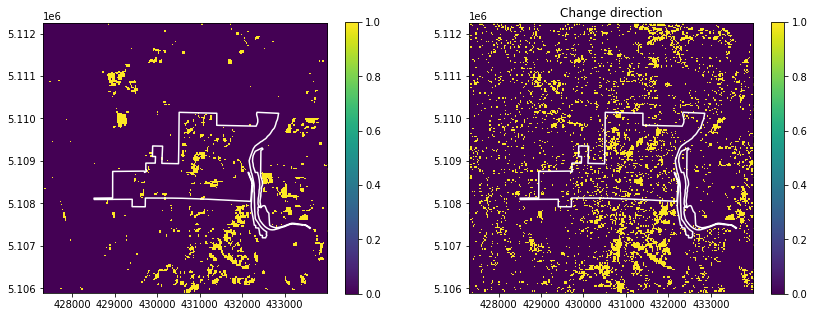

In [ ]:
# magnitude threshold
cva1 = change_magnitude > 0.10 # threshold
#cva1 = cva1.astype(np.uint8) # change from boolean to integer


# direction threshold
cva2 = (change_direction > 280) & (change_direction < 300) # set thresholds - a min & max are set to try to get rid of some of the noise

cva2 = cva2.astype(np.uint8) # change to integers


# plot the magnitude change map
fig, axs = plt.subplots(1,2, figsize=(14,5))

im1 = axs[0].imshow(cva1.reshape(rows,cols), vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[0])
plt.colorbar(im1, ax = axs[0])
axs[1].set_title("Change magnitude")

im2 = axs[1].imshow(cva2.reshape(rows,cols), vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[1])
plt.colorbar(im2, ax = axs[1])
axs[1].set_title("Change direction")

plt.show()



Overall, the change direction part of the CVA doesn't seem to work well for this study area - there is a lot of noise in the map.

# Conclusions

For the final step, we will compare the outputs of the different analyses.

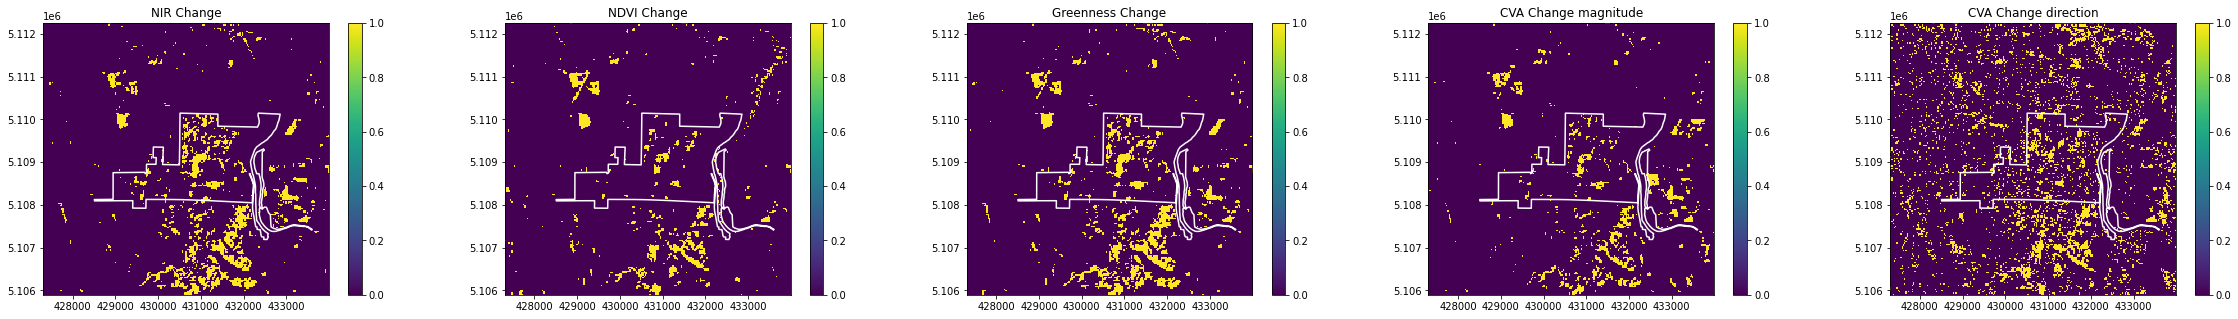

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True color composites


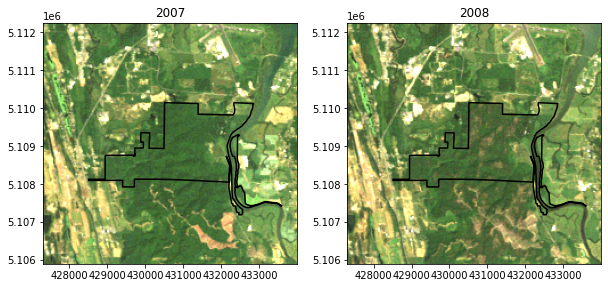

In [ ]:
# display all 3 difference images
fig, axs = plt.subplots(1,5,figsize=(40,5))
im1 = axs[0].imshow(NIR_changeim, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[0])
plt.colorbar(im1, ax=axs[0])
axs[0].set_title("NIR Change")

im2 = axs[1].imshow(change_ndvi, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[1])
plt.colorbar(im2, ax=axs[1])
axs[1].set_title("NDVI Change")

im3 = axs[2].imshow(change_kt_green, vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[2])
plt.colorbar(im3, ax=axs[2])
axs[2].set_title("Greenness Change")

im4 = axs[3].imshow(cva1.reshape(rows,cols), vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[3])
plt.colorbar(im4, ax = axs[3])
axs[3].set_title("CVA Change magnitude")

im5 = axs[4].imshow(cva2.reshape(rows,cols), vmin = 0, vmax = 1, interpolation='nearest', extent = extent)
study_area.boundary.plot(color = "white", ax=axs[4])
plt.colorbar(im5, ax = axs[4])
axs[4].set_title("CVA Change direction")

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 5)) #create canvas for first two plots
print('True color composites')
#2007 true color
study_area.boundary.plot(color = "black", ax=axs[0]) # add study area shapefile
axs[0].imshow(reshape_as_image(before[[2,1,0],:]*.001), extent = extent) # grab R, G, B bands for all pixels, scale the reflectance, and set the new extent
axs[0].set_title("2007")

#2008 true color
study_area.boundary.plot(color = "black", ax=axs[1])
axs[1].imshow(reshape_as_image(after[[2,1,0],:]*.001), extent = extent) # grab R, G, B bands for all pixels, scale the reflectance, and set the new extent
axs[1].set_title("2008")
plt.show()

The plots above can be compared to the true color imagery, where the disturbance areas within the park are visible. In looking at the outputs with the chosen thresholds, the Greenness change seems to be fairly accurate, as well as the NIR change. The CVA change direction has a lot of noise, and doesn't appear to pick out the disturbance areas much at all. Since we don't have polygons of the exact disturbance locations, we cannot perform accuracy assessments for the methods, but the comparison of these maps gives a general sense of which change detection method may be most useful for this study area.